In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision import datasets, transforms
from scipy.stats import entropy


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


#import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
logged_in = False

Using device: cpu


In [3]:
FOLDER_PATH = '/content/drive/MyDrive/Deep Learning/ex3_305673212_312349509/FashionMNIST'
if (os.path.exists(FOLDER_PATH)):
  _PATH = FOLDER_PATH
else:
  _PATH = "data" #for git runs

In [9]:
#hyper parameters
#TODO: the WGAN paper states lr= 5e-5, should we use it?
DIM = 64 # Model dimensionality
BATCH_SIZE = 256 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
GEN_ITERS = 200000 # How many generator iterations to train for
LATENT_DIM = 128
in_channels = 1
input_img_w = 28 #FashionMNIST Width
input_img_h = 28 #FashionMNIST Hight
OUTPUT_DIM = input_img_w*input_img_h # Number of pixels in MNIST (28*28)
CIFAR_SIZE = (32,32)


# W&B





In [10]:
#TODO: remove before submission
import wandb

if not logged_in:
    try:
        from mycreds import WANDB_API_KEY
        logged_in = wandb.login(key=WANDB_API_KEY)

    except ImportError:
        raise ImportError ("hi! its Nadav 😅\nprovide your WANDB_API_KEY in mycreds.py 🙏:\n"
              "1. Create a student/free account at https://wandb.ai/site 🔥\n"
              "2. copy your API key from https://wandb.ai/authorize\n"
              "3. create a file named mycreds.py in the same directory as this notebook\n"
              "4. add the following line to mycreds.py: WANDB_API_KEY = 'your API key'")

# Data Preprocessing
## Data loaders
let's prepare our data by loading it, normalizing it, and creating the data loaders.

In [11]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.ToTensor(),
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=_PATH, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)

## Visualize the data

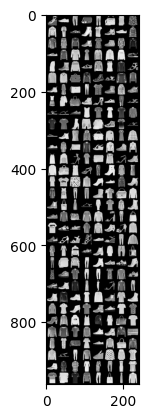

In [99]:
import torchvision


# Display some of the images
def imshow(img,title=''):
    #img = img / 2 + 0.5  # unnormalize

    npimg = img.cpu().detach().numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()


def show_grid(images,title=''):

    imshow(torchvision.utils.make_grid(images), title = title)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_grid(images)

# Network Architecture
We will implemnet gernerator and descriminator/critic as defined in "Improved Training of Wasserstein GANs" papaer for CIFAR10We decided to resize the FashionMNIST images from 28X28X1 to 32X32X1 to be able to use same conv layers used in the paper



# Generator

### conv dimensions
convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding


In [18]:

class Generator(nn.Module):
    def __init__(self,
                 latent_dim=LATENT_DIM,
                 dim= DIM):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 7*7*4*dim, bias=False),
            nn.BatchNorm1d(7*7*4*dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.reshape = nn.Unflatten(1, (4*dim, 7, 7))

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(4*dim, 2*dim,
                               kernel_size=5,
                               stride=1,
                               padding=2,
                               bias=False),
            nn.BatchNorm2d(2*dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(2*dim, dim,
                               kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(dim, 1,
                               kernel_size=5,
                               stride=2,
                               padding=2,
                               output_padding=1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self,
                n_samples,
                x = None):
        if x is None:
            x = torch.randn(n_samples, self.latent_dim).to(device)
        x = self.fc(x)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x

# Create the generator model
generator = Generator()

# Print the model architecture
print(generator)


Generator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (reshape): Unflatten(dim=1, unflattened_size=(256, 7, 7))
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bia

 # Discriminator

convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding

In [19]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self,
                 dim=DIM,
                 mode='wgan',
                 in_channels=1):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, dim, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(dim, 2*dim,
                      kernel_size=5,
                      stride=2,
                      padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(2*dim*7*7, 1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Create the discriminator model
discriminator = Discriminator()

# Print the model architecture
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=1, bias=True)
)


# Evaluation
## evaluation metric - Inception score
we define our evaluation metric as the inception score:

In [107]:
## Inception score (Evaluation)
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    
    def get_pred(x):
        with torch.no_grad():
            # Upsample images as InceptionV3 requires min 299x299
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            # InceptionV3 needs input shape of N x 3 x 299 x 299
            x = x.repeat(1, 3, 1, 1)
            x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()
    
    # Resize images to 299x299 as required by InceptionV3
    images = [TF.resize(img, (299, 299)) for img in images]
    images = torch.stack(images)
    
    # Calculate predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)
    
    # Calculate Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def disc_cost(disc_real, disc_fake, mode=None):
    real_labels = torch.ones_like(disc_real)
    fake_labels = torch.zeros_like(disc_fake)
    if mode == 'wgan':
        real_loss = F.binary_cross_entropy_with_logits(disc_real, real_labels)
        fake_loss = F.binary_cross_entropy_with_logits(disc_fake, fake_labels)
    else:
        real_loss = -torch.mean(disc_real)
        fake_loss = torch.mean(disc_fake)

    total_loss = real_loss + fake_loss
    return total_loss

def gen_cost(disc_fake,mode):
    return (-torch.mean(disc_fake) if mode == 'wgan' else F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake)))

## Test the generator
can be removed before submission

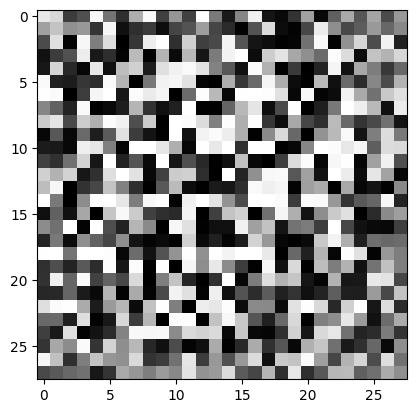

In [108]:
generator = Generator().to(device)
img = generator.forward(10)
imshow(img[0])

## Test the discriminator

In [109]:
discriminator = Discriminator().to(device)
output = discriminator.forward(img)
print(output)


tensor([[-0.0230],
        [ 0.0978],
        [-0.0103],
        [ 0.0872],
        [ 0.0687],
        [ 0.0972],
        [ 0.0729],
        [ 0.1411],
        [ 0.0141],
        [ 0.2032]], grad_fn=<AddmmBackward0>)


#Lost Function/ Inception

In [110]:
def clip_weights(net, clip_value):
    for p in net.parameters():
        p.data.clamp_(-clip_value, clip_value)

# Training loop

In [111]:
  #TODO: Consider change it if training is too heavey
def inf_train_gen(train_loader = train_loader):
    while True:
        for images, _ in train_loader:
            yield images


def train(generator = generator,
          discriminator = discriminator,
          batch_size=BATCH_SIZE,
          train_loader=train_loader,
          val_loader=test_loader,

          lr = 5e-5,
          gen_iters=GEN_ITERS,
          critic_iters=CRITIC_ITERS,
          clipping_value=0.01,
          mode='wgan',
          gradient_clipping = False,
          weight_clipping = False

          ):

    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)


    # wandb
    wandb.init(
        # set the wandb project where this run will be logged
        project="GANs",
        # track hyperparameters and run metadata
        config={
            f"learning_rate": 5e-5,
            f"architecture": "GAN",
            f"dataset": "Fashion MNIST",
        })
    # Watch the model to log gradients and parameters
    wandb.watch(generator, log="all", log_freq=100)
    wandb.watch(discriminator, log="all", log_freq=100)

    for iteration in range(gen_iters):
        start_time = time.time()

        # Train generator freeze discriminator for speedup
        generator.train()
        discriminator.eval()

        # forward pass
        gen_optimizer.zero_grad()
        fake_data = generator(batch_size)
        disc_fake = discriminator(fake_data)

        #loss, why is it called val?
        gen_cost_val = gen_cost(mode=mode,disc_fake=disc_fake)
        gen_cost_val.backward()
        gen_optimizer.step()

        # Train critic/dicriminator
        disc_iters = 1 if mode == 'dcgan' else critic_iters
        for _ in range(disc_iters):


            _data = next(inf_train_gen()).to(device)
            discriminator.train()
            disc_optimizer.zero_grad()


            disc_real = discriminator(_data)

            # forward pass
            fake_data = generator(batch_size)
            disc_fake = discriminator(fake_data)

            #loss
            disc_cost_val =disc_cost(mode=mode,disc_real=disc_real,disc_fake=disc_fake)
            #backprop
            disc_cost_val.backward()

            # TODO: hey 👋 I added grad and weight clipping to try prevent the exploding grads & weights
            #  in the discriminator. see if it stabilizes the training

            if gradient_clipping:
                # grad clipping only on the discriminator
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.1)
                disc_optimizer.step()

            # Apply weight clipping for WGAN
            if weight_clipping:
                clip_weights(discriminator, clipping_value)

        print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")
        wandb.log({"Generator Cost": gen_cost_val, "Discriminator Cost": disc_cost_val}, step=iteration)

        # Logging

        # Calculate inception score every 1K iters
        if iteration % 1000 == 999:
            with torch.no_grad():
                # z = torch.randn(1000, 100, 1, 1).to(device) this will break the code because it doesn't match the generator latent dimension
                generated_imgs = generator(100)
                generated_imgs = generated_imgs.cpu()
                inception_mean, inception_std = inception_score(generated_imgs)
                print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
                wandb.log({"Inception Score": inception_mean}, step=iteration)

                torch.save(generator.state_dict(), f"models/generator{iteration//1000}.pth")
                torch.save(discriminator.state_dict(), f"models/discriminator{iteration//1000}.pth")

                imshow(generated_imgs[0])
                plt.show()

        # Calculate val loss of the discriminator and generate samples every 100 iters
        if iteration % 100 == 99:

            val_disc_costs = []
            for images, _ in val_loader:
                # images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
                fake_data = generator(batch_size)
                disc_fake = discriminator(fake_data)
                _dev_disc_cost = disc_cost(mode=mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
                val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
                wandb.log({"Validation Discriminator Cost": _dev_disc_cost}, step=iteration)

            imshow(fake_data[0])
            plt.show()



        # mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot


# Training a WGAN

In [113]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
train(mode = 'wgan'
      , train_loader=train_loader
      , gen_iters = GEN_ITERS
      , critic_iters=CRITIC_ITERS
      ,batch_size = BATCH_SIZE
      ,discriminator = discriminator
      ,generator = generator
      ,val_loader=test_loader,
      gradient_clipping=True,
      weight_clipping=True)

# Training a  DCGAN


In [98]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
train(mode = 'dcgan'
      , train_loader=train_loader
      , gen_iters = GEN_ITERS
      , critic_iters=CRITIC_ITERS
      ,batch_size = BATCH_SIZE
      ,discriminator = discriminator
      ,generator = generator
      ,val_loader=test_loader)

# load the pretrained Generator to generate samples!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49588838..0.9987221].


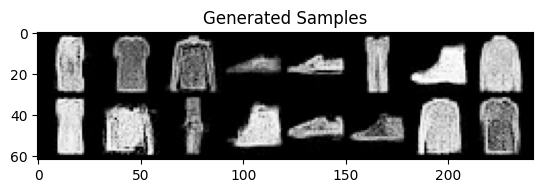

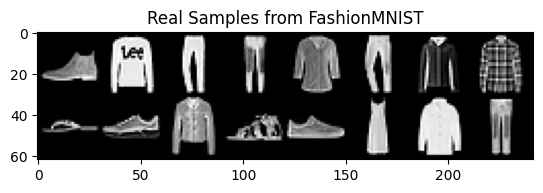

In [105]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("models/generator75.pth", map_location=device))

# generate 16 samples
n_samples = 16
imgs = generator(n_samples)
show_grid(imgs, title="Generated Samples")

real_imgs = test_dataset.data[:16].unsqueeze(1).float().to(device) / 255.
show_grid(real_imgs, title="Real Samples from FashionMNIST")


